# Exercise session 1 - Introduction and Dead Reckoning

This exercise session is comprised of two parts. The goal of the first part is to familiarize you with the software that we will be using for the exercise sessions. Next, we'll take a look at one of the very first (and most basic) localization methods: dead reckoning. Your goal is to learn what this method actually is, what its limitations are and where we can and cannot use this method. You will also learn more about “error ellipses” and how to understand them.

## Preparation

In order to be productive during this exercise session, you will have to:

* Read the getting started page
* Read the turtlebot toolbox documentation
* Study the part of “dead reckoning” of your course. Understanding the concept of error ellipses is important for this exercise session. An introductory text can be found on Toledo.

## Questions to hand in before the session starts

What is the difference between a function and a script (regular MATLAB-file)?

1.   What function will you use to find out how far your robot has driven ?
2.   Let’s assume a 1D movement: you are moving at 1m/s and every second, you
know that you have an error of +/- 0.1m.
3.   Draw the error “ellipses” of 3 steps (1 second between each step), starting from a certain intial position.
4.   Are these still error ellipses (Or are they something else) ?
5.   What can you conclude about your position after those 3 steps? And after 10 steps (no drawing required).


# Introduction & warm up exercises
First, we need to make sure that all neccesary libraries are installed (only required at the very beginning)

In [ ]:
# pip uninstall MobileRoboticsGT

In [ ]:
#!python -m pip install git+https://github.com/RobinAmsters/Mobile_Robotics_Exercises.git
#!pip install filterpy
#!sudo apt install python3-gi gobject-introspection gir1.2-gtk-3.0

In [2]:
import filterpy
import matplotlib.pyplot as plt
import numpy as np

To get a feel for how this works, we will now make a few introductory programming exercises. These should not take more than a few minutes each.

## Write a program that will print the squares of the even numbers between 5 and 10.

In [ ]:
# Solution 1
for i in range(6,11, 2):
  print(i**2)

# Solution 2
for i in range(5, 11):
  if i%2==0:
    print(i**2)

## Plot a line graph of the following equation: $y=2x^2+5$


In [ ]:
x = np.linspace(-100,100, 100)
y = 2*x**2 +  5
plt.figure()
plt.plot(x,y)
plt.show()

# Toolbox specific exercises/preparation (TODO)
Make your robot drive a straigth line of 2m

Plot error ellips (with filterpy)

preparation/warmup: bar chart


In [ ]:
from filterpy.stats import plot_covariance_ellipse
import matplotlib.pyplot as plt

P = [[2, 0], [0, 6]]
plot_covariance_ellipse((2, 7), P, fc='g', alpha=0.2, 
                        std=[1],
                        title='|2 0|\n|0 6|')
#plt.gca().grid(b=True)

# Bayes' Rule (TODO)

# Discrete Bayes

Simple estimator

Will lead us to the Kalman filter (next session)

During this session, we will be making exercises based on the 'dog tracking' example explained in the book "Kalman and Bayesian Filters in Python" by Roger Labbe. Further details can be found in chapter 2 - Discrete Bayes. The book also contains usefull theory about kalman filters, and is highly recommended as supplementary material. Similar to this course, the book is available in jupyter notebook format and can be freely downloaded here: https://github.com/rlabbe/Kalman-and-Bayesian-Filters-in-Python

In these exercises, our aim is to track the location of a dog in a hallway. In order to keep the problem somewhat tractable, we will be using a few assumptions:
 - The position of the dog can be described by one variable (i.e. the distance from the beginning of the hallway).
 - Their are 10 unique positions in the hallway where our dog can be located.
 - The hallway is circular or rectangular. That means that whenever the dog reaches the last position in the hallway, moving forward will put him/her again at the beginning of the hallway.

## Predicting movement

### Exercise 1

Suppose you have a discrete initial distribution of the position of the dog (represented by x), given by:

| 0.0 | 0.0 | 0.0 | 0.25 | 0.0 | 0.5 | 0.0 | 0.25 | 0.0 | 0.0 |
|-----|------|-----|-----|-----|------|

The prediction model of a movement step is given by:

$p(x=k|x=k)$ = 0.4
$p(x=k+1|x=k)$ = 0.2
$p(x=k+2|x=k)$ = 0.1
$p(x=k-1|x=k)$ = 0.2 
$p(x=k-2|x=k)$ = 0.1

Assume a movement $u = 2$ spaces. What will be the probability distribution after movement? First try to find the solution on paper, then adapt the code below to verify your result

**TODO: code given should be adapted from predict_perfect (potentially with one or two p_under/over)**

[0.05  0.025 0.    0.025 0.05  0.15  0.15  0.25  0.15  0.15 ]


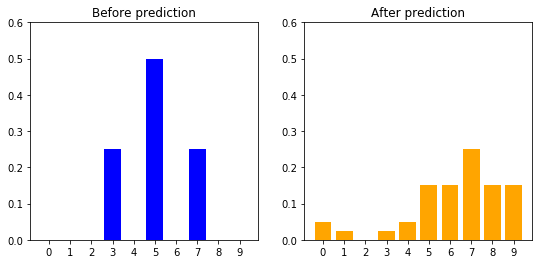

In [20]:
import book_format
from book_plots import bar_plot
book_format.set_style()

belief = [0.0, 0.0, 0.0, 0.25, 0.0, 0.5, 0.0, 0.25, 0.0, 0.0]
n = len(belief)
move=2
p_minus_2 = 0.1
p_minus_1 = 0.2
p_correct = 0.4
p_plus_1 = 0.2
p_plus_2 = 0.1

def predict_move(belief, move, p_minus_2, p_minus_1, p_correct, p_plus_1, p_plus_2):
    n = len(belief)
    prior = np.zeros(n)
    for i in range(n):
        prior[i] = (
            belief[(i-move+2) % n] * p_minus_2 + 
            belief[(i-move+1) % n] * p_minus_1 + 
            belief[(i-move) % n]   * p_correct +
            belief[(i-move-1) % n] * p_plus_1 +
            belief[(i-move-2) % n] * p_plus_2)      
    return prior

prior = predict_move(belief, move, p_minus_2, p_minus_1, p_correct, p_plus_1, p_plus_2)
print(prior)

plt.subplot(121)
bar_plot(belief, title='Before prediction', ylim=(0, .6), c="blue")
plt.subplot(122)
bar_plot(prior, title='After prediction', ylim=(0, .6), c="orange")

### Exercise 2

Let us now move on to a slightly more complicated example. Suppose you the initial distribution of the dog position x is given by:

| 0.0 | 0.0 | 0.0 | 0.1 | 0.8 | 0.1 |0.0 | 0.0 |0.0 | 0.0 |
|-----|------|-----|-----|-----|------|-----|------|-----|-----|-----|

The prediction model of a movement step is given by:

$p(x=k|x=k)$ = 0.6
$p(x=k+1|x=k)$ = 0.15
$p(x=k+2|x=k)$ = 0.04
$p(x=k+3|x=k)$ = 0.01
$p(x=k-1|x=k)$ = 0.15
$p(x=k-2|x=k)$ = 0.04
$p(x=k-3|x=k)$ = 0.01

Assume a movement u = 1 is made every timestep. Extend your previous code to calculate the probality distribution after prediction. You do not need to calculate this example by hand. 


What will be the probability distribution after 2 movement steps?  What about after 5?

**TODO: give them loop**

In [ ]:
import book_format
from book_plots import bar_plot
book_format.set_style()

belief = [0.0, 0.0, 0.0, 0.1, 0.8, 0.1, 0.0, 0.0, 0.0, 0.0]
n = len(belief)
move=1
p_minus_3 = 0.01
p_minus_2 = 0.04
p_minus_1 = 0.15
p_correct = 0.6
p_plus_1 = 0.15
p_plus_2 = 0.04
p_plus_3 = 0.01

def predict_move(belief, move, p_minus_3, p_minus_2, p_minus_1, p_correct, p_plus_1, p_plus_2, p_plus_3):
    n = len(belief)
    prior = np.zeros(n)
    for i in range(n):
        prior[i] = (
            belief[(i-move+3) % n] * p_minus_3 +
            belief[(i-move+2) % n] * p_minus_2 + 
            belief[(i-move+1) % n] * p_minus_1 + 
            belief[(i-move) % n]   * p_correct +
            belief[(i-move-1) % n] * p_plus_1 +
            belief[(i-move-2) % n] * p_plus_2 +
            belief[(i-move-3) % n] * p_plus_3)      
    return prior

plt.subplot(121)
bar_plot(belief, title='Before prediction', ylim=(0, .6), c="blue")

n_predictions = 5
prior = belief
print("Number of prediction steps: ", n_predictions)

for i in range(n_predictions):
    prior = predict_move(prior, move, p_minus_3, p_minus_2, p_minus_1, p_correct, p_plus_1, p_plus_2, p_plus_3)
print(prior)


plt.subplot(122)
bar_plot(prior, title='After ' + str(n_predictions) + ' predictions', ylim=(0, .6), c="orange")

# Dead reckoning (TODO)

Let us now go to a more practical example: robot localization. We saw that prediction reduces accuracy, lets look at some practical consequences of that.

ideas: 
 - robot can drive into something?
 - (evolution of) uncertainty ellipses

For the purpose of this example, we are technically not using a discrete bayes filter. Rather, a kalman filter with no updates (learn what KF is later, for now, is multidimensional estimator). For the purposes of our example, the distinction is not so imporant, as the overall idea is the same. 


# Incorporating measurements 
As we saw before, only predition not great. How do we solve it? By adding information. 

Lets assume our dog has a sensor tied to its back, that can detect the presence of a door. The sensor is very simple, and returns a "1" when the dog stands next to a door, and a "0" when there is no door. In the following exercises, we will improve our location estimator by including this information. 


Ex4: can you see what happens when we don't have regular observations?


### Exercise 3
Now let's create a map of the hallway. We'll place the first two doors close together, and then another door further away. 

In [22]:
hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])

Based on the first sensor reading, we can intialize our probability distribution. Complete the code below to obtain the initial probability distribution:

**TODO give them some basics for counting doors etc**

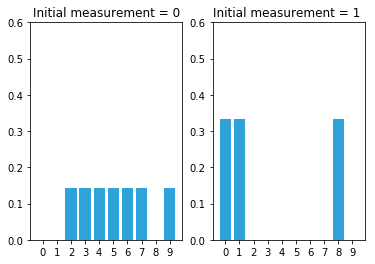

In [48]:
import book_plots
import numpy 

def initial_distribution(z_0, hallway):
    """
        Calculate the initial probability distribution
        z_0: first measurement returned by sensor
        hallway: layout of the hallway. "1" represents a door at that location, "0" indicates a wall.
    """
       
    if z_0 == 0:
        n_wall = len(np.where(hallway == 0)[0]) # Count number of zeros in hallway
        hallway_flipped = 1 - hallway # Switch ones and zeros
        belief = (1.0/n_wall)*hallway_flipped
        
    elif z_0 == 1:
        
        n_door = len(np.where(hallway)[0]) # Count number of ones in hallway
        belief = (1.0/n_door)*hallway
        
    else:
        print("Initial measurement invalid")
        belief = np.nan
        
    return belief

# Initial distribution when a wall is measured
belief_0 = initial_distribution(0, hallway)

# Initial distribution when a door is measured
belief_1 = initial_distribution(1, hallway)

plt.subplot(121)
book_plots.bar_plot(belief_0, title='Initial measurement = 0', ylim=(0, .6))
plt.subplot(122)
book_plots.bar_plot(belief_1, title='Initial measurement = 1 ', ylim=(0, .6))

### Exercise 4
Now that we have our initial distribution, we need to keep it up to date as new information comes in. 

Lets say our dog is stationary for now, 

('belief:', array([0.1875, 0.1875, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625, 0.0625,
       0.1875, 0.0625]))
('sum =', 1.0)


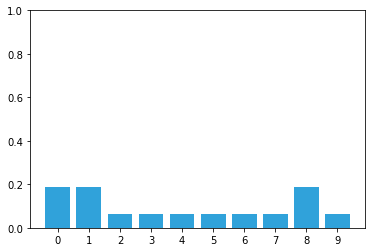

In [83]:
from filterpy.discrete_bayes import normalize
def update(hall, belief, z, z_prob): 
    scale = z_prob / (1. - z_prob)
    belief[hall==z] *= scale
    normalize(belief)
    return belief

belief = np.array([0.1] * 10)
reading = 1 # 1 is 'door'
belief = update(hallway, belief, z=reading, z_prob=0.75)
print('belief:', belief)
print('sum =', sum(belief))
plt.figure()
book_plots.bar_plot(belief)

## Putting it all together

We have already programmed the update and predict steps. All we need to do is feed the result of one into the other, and we will have implemented a dog tracker!!! Let's see how it performs. We will input measurements as if the dog started at position 0 and moved right one position each epoch. As in a real world application, we will start with no knowledge of his position by assigning equal probability to all positions. 

### Exercise 5

Make a complete loop below:

Step trough the different iterations and check if everything is working as expected:

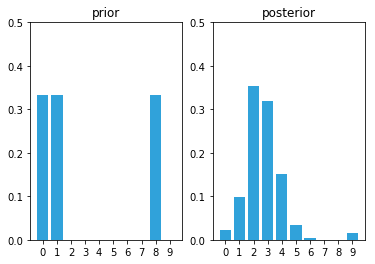

In [86]:
import book_plots

def predict_move(belief, move, p_under, p_correct, p_over):
    n = len(belief)
    prior = np.zeros(n)
    for i in range(n):
        prior[i] = (
            belief[(i-move) % n]   * p_correct +
            belief[(i-move-1) % n] * p_over +
            belief[(i-move+1) % n] * p_under)      
    return prior

# def update(hall, belief, z, z_prob): 
#     scale = z_prob / (1. - z_prob)
#     belief[hall==z] *= scale
#     normalize(belief)
#     return belief

hallway = np.array([1, 1, 0, 0, 0, 0, 0, 0, 1, 0])
belief = initial_distribution(1, hallway)

move = 1
p_correct = 0.8
p_under = 0.1
p_over = 0.1

prior = belief
for i in range(3):
    prior = predict_move(prior, move, p_under, p_correct, p_over)
    posterior = update(hallway, prior, hallway[i], 0.75)
    prior = posterior
    
book_plots.plot_prior_vs_posterior(belief, posterior, ylim=(0,.5))

# Further reading

Kalman and Bayesian Filters in python, chapter 2: Discrete-Bayes

Taboga, Marco (2017). "Bayes' rule", Lectures on probability theory and mathematical statistics, Third edition. Kindle Direct Publishing. Online appendix. https://www.statlect.com/fundamentals-of-probability/Bayes-rule.

http://gtribello.github.io/mathNET/bayes-theorem-problems.html


